## Incident forecasting with VCDB 

In complement to the forecasting model based on the Mørketallsundersøkelser (see [here](walkthrough_survey.ipynb)), an alternative forecasting model was developed based on data from the [Veris Community Database](https://verisframework.org/vcdb.html). In contrast to the survey-based model, the VCDB-based model cannot predict the number of incidents expected to occur in the future. This is because VCDB -- and similar databases of reported incidents, such as [Hackmaggeddon](https://www.hackmageddon.com/) -- only contains a tiny fraction of the set of incidents that have occurred, with a strong bias towards certain types of incidents (which end up being mentioned in online news channels, and therefore reported in VCDB). However, the dataset can help us answering slightly different question: _given that an incident occurs in the future, what will be its expected properties_?



### Data

The incidents registered on VCDB are characterised by the following key properties:
- `action`: the threat actions describe what the threat actor(s) did to cause or contribute to the incident
- `actor`: the (external or internal) entities that cause or contribute to an incident
- `asset`: the assets that were compromised during the incident
- `attribute`: the security attributes were compromised during the incident, grouped under *confidentiality*, *integrity*, and *availability*. 
- `victim`: what is known about the organisation affected by the incident
- `impact`: the type and magnitudes of the losses caused by the incident in the organisation
- `timeline`: when the incident occurred, as well as the time it took to compromise, discovery and containment

The above properties are themselves decomposed in multiple sub-properties -- for instance, the "hacking" action are defined by a variety, a vector, and a result. 

Some additional information such as the discovery method, corrective actions, secondary victims, control failures, value chain, etc. are also specified in at least a subset of incidents, but are not included as predictive elements in the current implementation (although they could be added relatively easily if needed). Incidents are also associated with a unique identifier as well as online references mentioning the incident. 

For convenience, the incidents have already been processed and stored in the `data/vcdb.json` file, and can be loaded like this:

In [1]:
import sys, os 
sys.path.append(os.path.abspath(os.path.join('..')))
from lefsa import osint_data
vcdb_incidents = osint_data.VCDB.load_from_json('../data/vcdb.json')

impact.loss.brand_damage.amount for incident 6390A0A5-5990-4F69-B5A4-712D253E7743 is unreasonably large: 1000000000000 (most likely a data error), capping it to 1e9 USD
impact.overall_amount for incident 6390A0A5-5990-4F69-B5A4-712D253E7743 is unreasonably large: 1000000000000 (most likely a data error), capping it to 1e9 USD


The incidents are available in two form: a "raw" form representing the original JSON data in VCDB, and a processed form where the data has been flattened and standardized. In particular, the processed incidents replaced the embedded dictionaries with a flat representation of all variables (using dot notation for nested fields). The incidents are also standardised by:
- mapping countries to world regions
- adding an incident *date* feature
- converting timeline durations to pandas timedeltas
- replacing 'Unknown' values with NaN
- converting all monetary amounts to USD
- shortening [NAICS](https://www.naics.com/) codes to a specified length
- simplifying victim employee counts into 'Small' and 'Large'

The two forms can be easily retrieved:

In [2]:
import pprint
import numpy as np
pp = pprint.PrettyPrinter(indent=2)

print("Original (nested) incident data\n==========")
pp.pprint(vcdb_incidents.raw_incidents[4])

print("\nFlattened and standardised form:\n==========")
incident = vcdb_incidents.incidents[4]
for key, value in incident.items():
    if (type(value) == bool and not value) or (type(value)==float and np.isnan(value)):  # For brevity, skip False and NaN values
        continue
    print(f"{key}: {value}")

Original (nested) incident data
{ 'action': { 'error': { 'notes': 'Unknown',
                         'variety': ['Loss'],
                         'vector': ['Carelessness']}},
  'actor': {'internal': {'motive': ['NA'], 'variety': ['Unknown']}},
  'asset': {'assets': [{'variety': 'M - Disk drive'}], 'cloud': ['Unknown']},
  'attribute': { 'availability': {'variety': ['Loss']},
                 'confidentiality': { 'data': [{'variety': 'Personal'}],
                                      'data_disclosure': 'Yes',
                                      'data_victim': ['Customer'],
                                      'state': ['Stored']}},
  'discovery_method': {'unknown': True},
  'impact': {'overall_rating': 'Unknown'},
  'incident_id': 'BF033213-06B9-4021-BB56-DAB66E5EDBDF',
  'plus': { 'analysis_status': 'First pass',
            'analyst': 'swidup',
            'asset': {'total': 'No'},
            'attribute': { 'confidentiality': { 'credit_monitoring': 'Yes',
                     

The incidents can then be split into training and test sets for model estimation and evaluation.  The method `split_train_test` takes out the most recent proportion of incident (based on a provided ratio) and returns two pandas DataFrame, one for training and one for testing.

In [3]:
train_df, test_df = vcdb_incidents.split_train_test(test_ratio=0.2)
print(f"\nTrain set size: {len(train_df)}, Test set size: {len(test_df)}")
print("Number of columns:", len(train_df.columns))


Train set size: 8316, Test set size: 2079
Number of columns: 1086


To avoid overfitting, we remove variables that are rarely specified in the incident reports. More precisely, the split_train_test method has a `min_nb_incidents_for_col` parameter (defaulting to 10) which only retains variables that are present in at least this number of incidents in the training set, and at least once in the test set. Boolean variables are also set to a default value of `False`, while other variables have a default value of `NaN`.

We can further distinguish between three types of variables:
- purely *informative* variables that are useful for debugging and exploratory analysis, but neither represent an input feature nor a variable to predict. This include for instance the reference pointers, summary, method of discovery, etc.
- *input features* representing information that is known before the incident, such as the date and the features of the organisation
- *target features* that may be useful/interesting to predict

The distribution of columns in those three groups can be done with the `classify_columns` method:

In [4]:
info_cols, input_cols, target_cols = osint_data.classify_columns(train_df)
print("Nb. of informative columns:", len(info_cols))
print("Nb. of input columns:", len(input_cols))
print("Nb. of target columns:", len(target_cols))

print("\nList of input columns:")
print(input_cols)

print("\nList of target columns:")
print(target_cols)

Nb. of informative columns: 536
Nb. of input columns: 12
Nb. of target columns: 538

List of input columns:
['timeline.incident.date', 'victim.continent', 'victim.country', 'victim.employee_count', 'victim.employee_count_simplified', 'victim.government', 'victim.industry_naics_2', 'victim.industry_naics_3', 'victim.industry_naics_4', 'victim.industry_naics_5', 'victim.industry_naics_6', 'victim.revenue.amount']

List of target columns:
['action.environmental', 'action.environmental.variety.fire', 'action.environmental.variety.humidity', 'action.environmental.variety.hurricane', 'action.environmental.variety.power_failure', 'action.error', 'action.error.variety.capacity_shortage', 'action.error.variety.classification_error', 'action.error.variety.data_entry_error', 'action.error.variety.disposal_error', 'action.error.variety.gaffe', 'action.error.variety.loss', 'action.error.variety.maintenance_error', 'action.error.variety.malfunction', 'action.error.variety.misconfiguration', 'action.

As can be observed above, many variables are boolean indicators, such as `action.environmental.variety.fire` indicating whether the incident involved fire as an environmental action. Note that this one-hot encoding is often necessary as VCDB allows an action to have multiple varieties (e.g. both 'fire' and `hurricane`).

### Predicting target variables

Our goal is to predict some of those target variables mentioned above based on input features, such that we can find out the likelihoods of various types of incidents depending on what we know about the organisation. We have implemented several approaches:
- a "dummy" predictor that merely predicts the most frequent value for the target variable (or the median value in case of numeric variables)
- a machine learning approach based on [AutoGluon](https://auto.gluon.ai), which is a popular toolkit to train state-of-the-art models for tabular prediction tasks.
- a kernel-based classification/regression approach, which allows us to ask any type of conditional query $P(target\_var | conditions)$, such as "*if we observe a hacking action of a particular type, which assets are most likely to be affected?*" or "*what would be the most likely impacts of an incident caused by a Russian-backed threat actor?*"

#### Dummy forecaster 
The simplest approach is a dummy forecaster, which ignores all input variable and simply predicts the most frequent value observed in the training set for each variable (or the median value in case of numbers). Although this forecaster is very simple, it provides a good baseline to assess what can be expected of a naive statistical approach.

The forecaster can be estimated for all target variables like this:

In [5]:
from lefsa.osint_base import DummyForecaster
dummy_forecaster = DummyForecaster("dummy")
dummy_forecaster.train(train_df, target_cols)

==> Fitting 538 predictors


  1%|          | 4/538 [00:00<00:14, 37.53it/s]

100%|██████████| 538/538 [00:20<00:00, 25.87it/s]


The forecaster can then be used to make predictions on the test set. The method `predict_all` returns three outputs:
- a dataframe expressing the predicted value for each target variable given the inputs (for the dummy predictors, those are simply ignored)
- a dictionary mapping each *discrete-valued* target variable to a dataframe expressing the probability of each possible value
- a dictionary mapping each *numeric* target variable to a dataframe expressing the lower and higher bounds for the prediction

Here is a simple example:

In [6]:
test_df_inputs = test_df[input_cols]
targets_to_predict = ["action.environmental", "action.environmental.variety.fire", "impact.overall_rating", "impact.overall_amount"]
predictions, prob_distribs, conf_intervals = dummy_forecaster.predict_all(test_df_inputs, targets_to_predict)
predictions

,action.environmental,action.environmental.variety.fire|action.environmental,impact.overall_rating,impact.overall_amount
incident_id,,,,
98A797A1-D470-46DE-BA7E-0B294784B5CA,False,False,Insignificant,270000.0
2DE89A34-9D37-494F-9F72-AD2C48A044E4,False,False,Insignificant,270000.0
BD47CA16-5F24-4192-B1BD-BAAF5F37FF77,False,False,Insignificant,270000.0
fe3911d0-c8f0-11e9-9c16-3f32faecab86,False,False,Insignificant,270000.0
BF033213-06B9-4021-BB56-DAB66E5EDBDF,False,False,Insignificant,270000.0
...,...,...,...,...
54D682E2-479C-4644-A504-872166386DC9,False,False,Insignificant,270000.0
189DEBB6-5086-4ED1-A59F-974BE0D4B83C,False,False,Insignificant,270000.0
84D3682A-F418-4F8F-9E32-18FEE24D62B4,False,False,Insignificant,270000.0


As expected, the dummy forecaster simply returns default values for each row of the test set (indexed by their `incident_id`). 

**Important note**: that the predictions for the variable `action.environmental.variety.fire` are given *conditional* to `action.environmental` being True (as the variable does not make sense otherwise), which is the reason for the suffix `|action.environmental` in the column name. For instance, if we look at the probability distribution for this fire variety, its probability of being True is 0.2, as this variety has been observed once in a set of five incidents involving an "environmental" action:

In [7]:
prob_distribs["action.environmental.variety.fire|action.environmental"]

action.environmental.variety.fire,False,True
incident_id,,
98A797A1-D470-46DE-BA7E-0B294784B5CA,0.8,0.2
2DE89A34-9D37-494F-9F72-AD2C48A044E4,0.8,0.2
BD47CA16-5F24-4192-B1BD-BAAF5F37FF77,0.8,0.2
fe3911d0-c8f0-11e9-9c16-3f32faecab86,0.8,0.2
BF033213-06B9-4021-BB56-DAB66E5EDBDF,0.8,0.2
...,...,...
54D682E2-479C-4644-A504-872166386DC9,0.8,0.2
189DEBB6-5086-4ED1-A59F-974BE0D4B83C,0.8,0.2
84D3682A-F418-4F8F-9E32-18FEE24D62B4,0.8,0.2


Those preconditions are important to keep in mind when interpreting the results -- otherwise, one may be misled into thinking that the probability of fire is 0.2 in all incidents, whereas it is actually 0.2 only in those incidents *where an environmental action took place*.

Numeric variables such as `impact.overall_amount` have a 95% confidence interval associated with them:

In [8]:
conf_intervals["impact.overall_amount"]

,2.5 %,97.5 %
incident_id,,
98A797A1-D470-46DE-BA7E-0B294784B5CA,1180.0,2.112000e+08
2DE89A34-9D37-494F-9F72-AD2C48A044E4,1180.0,2.112000e+08
BD47CA16-5F24-4192-B1BD-BAAF5F37FF77,1180.0,2.112000e+08
fe3911d0-c8f0-11e9-9c16-3f32faecab86,1180.0,2.112000e+08
BF033213-06B9-4021-BB56-DAB66E5EDBDF,1180.0,2.112000e+08
...,...,...
54D682E2-479C-4644-A504-872166386DC9,1180.0,2.112000e+08
189DEBB6-5086-4ED1-A59F-974BE0D4B83C,1180.0,2.112000e+08
84D3682A-F418-4F8F-9E32-18FEE24D62B4,1180.0,2.112000e+08


#### Machine learning-based forecaster

To improve upon this simple baseline, we have implemented a machine learning approach based on [AutoGluon](https://auto.gluon.ai), which is a popular toolkit to train state-of-the-art models for tabular prediction tasks. A key advantage of AutoGluon is its ability to optimise the full pipeline, including preprocessing steps (e.g. imputation of unknown values, scaling, encoding of categorical variables, etc.) and the tuning of hyper-parameters.

We have tested Autogluon in two distinct setups: one limited to the estimation of gradient-boosted decision trees (GBM) and one including all standard predictive models available in AutoGluon (including e.g. feedforward neural networks and ensembles). Gluon-based forecasters can be trained in this manner:

In [9]:
from lefsa.osint_gluon import GluonForecaster
gluon_forecaster = GluonForecaster("gluon_forecaster", model_type="gbm")
gluon_forecaster.train(train_df, input_cols, targets_to_predict)  # Train only 3 target columns for speed

==> Training 4 predictors, each given 12 input features
Fitting predictor for action.environmental
Output value distribution: {False: 8311, True: 5}
Fitting gbm models with a time limit of 120 secs and storing it in gluon_forecaster/action.environmental


Fitting predictor for action.environmental.variety.fire
Conditioned on: action.environmental being True
Output value distribution: {False: 4, True: 1}
Fitting gbm models with a time limit of 120 secs and storing it in gluon_forecaster/action.environmental.variety.fire


Fitting predictor for impact.overall_rating
Output value distribution: {'Insignificant': 119, 'Distracting': 60, 'Damaging': 57, 'Painful': 26}
Fitting gbm models with a time limit of 120 secs and storing it in gluon_forecaster/impact.overall_rating
Fitting predictor for impact.overall_amount
Output value statistics: {'count': 265.0, 'mean': 21078161.117962264, 'std': 104384365.00155132, 'min': 20.0, '25%': 55000.0, '50%': 270000.0, '75%': 1700000.0, 'max': 1000000000.0}
Fitting gbm models with a time limit of 120 secs and storing it in gluon_forecaster/impact.overall_amount


Disabling calibration for metric `pinball_loss` due to having fewer than 1000 rows of validation data for calibration, to avoid overfitting (53 rows). Force calibration via specifying `calibrate=True`. (calibrate='auto')


And we can obtain the predictions as before:

In [10]:
test_df_inputs = test_df[input_cols]
predictions, prob_distribs, conf_intervals = gluon_forecaster.predict_all(test_df_inputs, targets_to_predict)
predictions

,action.environmental,action.environmental.variety.fire|action.environmental,impact.overall_rating,impact.overall_amount
incident_id,,,,
98A797A1-D470-46DE-BA7E-0B294784B5CA,False,False,Insignificant,2.690433e+05
2DE89A34-9D37-494F-9F72-AD2C48A044E4,False,False,Insignificant,2.592614e+05
BD47CA16-5F24-4192-B1BD-BAAF5F37FF77,False,False,Insignificant,1.253913e+06
fe3911d0-c8f0-11e9-9c16-3f32faecab86,False,False,Insignificant,1.164026e+06
BF033213-06B9-4021-BB56-DAB66E5EDBDF,False,False,Insignificant,2.690433e+05
...,...,...,...,...
54D682E2-479C-4644-A504-872166386DC9,False,False,Insignificant,1.824222e+05
189DEBB6-5086-4ED1-A59F-974BE0D4B83C,False,False,Insignificant,2.145814e+05
84D3682A-F418-4F8F-9E32-18FEE24D62B4,False,False,Insignificant,3.685105e+05


We can observe that the predictions of this Gluon-based forecaster do now change according to the input features associated with each incident, leveraging patterns learned from the training data.

#### Evaluation 
We can empirically compare the performance of our two forecasters (dummy and AutoGluon-based) on our three variables:

In [11]:
import pandas

print("Evaluation results for DummyForecaster:")
dummy_results = dummy_forecaster.evaluate(test_df, targets_to_predict, verbose=False)
display(dummy_results)

print("\nEvaluation results for GluonForecaster:")
gluon_results = gluon_forecaster.evaluate(test_df, targets_to_predict, verbose=False)
display(gluon_results)


Evaluation results for DummyForecaster:
=== Evaluating forecaster: dummy


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

=== Finished evaluation for forecaster: dummy


,accuracy,precision,recall,f1,log_loss,roc_auc,mse,mae,mape
action.environmental,0.999519,NaN,0.000000,0.000000,0.004168,0.5,NaN,NaN,NaN
action.environmental.variety.fire|action.environmental,0.000000,NaN,0.000000,0.000000,1.609438,NaN,NaN,NaN,NaN
impact.overall_rating,0.385965,0.385965,0.385965,0.214968,1.324095,0.5,NaN,NaN,NaN
impact.overall_amount,NaN,NaN,NaN,NaN,NaN,NaN,3.899596e+15,1.882853e+07,55.966392



Evaluation results for GluonForecaster:
=== Evaluating forecaster: gluon_forecaster


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]

=== Finished evaluation for forecaster: gluon_forecaster


,accuracy,precision,recall,f1,log_loss,roc_auc,mse,mae,mape
action.environmental,0.999519,NaN,0.00000,0.000000,0.004904,0.492782,NaN,NaN,NaN
action.environmental.variety.fire|action.environmental,0.000000,NaN,0.00000,0.000000,1.386294,NaN,NaN,NaN,NaN
impact.overall_rating,0.456140,0.476596,0.45614,0.352779,1.244934,0.683653,NaN,NaN,NaN
impact.overall_amount,NaN,NaN,NaN,NaN,NaN,NaN,3.889223e+15,1.877334e+07,47.113908


The most important metrics here are the log loss and ROC-AUC for classification targets, and the MAE (mean absolute error) for regression targets. Indeed, given the very limited information given as input features (basic properties of the organisation) and the general stochasticity of the task, we shouldn't expect the model to provide precise predictions about the nature of the threat actors, actions and impacts on the organisation of a future incident. Rather, what we should expect from the model are probabilistic estimates that are well calibrated and able to capture the influence of various input features. 

We can see that the GluonForecaster  outperforms the DummyForecaster on `action.environmental.variety.fire|action.environmental` and `impact.overall_rating`, and to a more limited extent on `impact.overall_amount`, although a large MAE remains. This is due to the fact that the amounts specified in VCDB are 1) only provided for a small subset of incidents and 2) show very large fluctuations, with a mean that is 78x the value of the median:

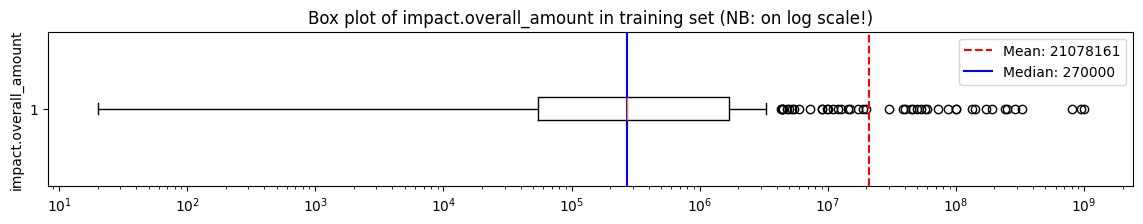

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 2))
plt.boxplot(train_df["impact.overall_amount"].dropna(), vert=False)
plt.xscale('log')
plt.ylabel('impact.overall_amount')
plt.title('Box plot of impact.overall_amount in training set (NB: on log scale!)')

# Show mean and median
mean_val = train_df["impact.overall_amount"].mean()
median_val = train_df["impact.overall_amount"].median()
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.0f}')
plt.axvline(median_val, color='blue', linestyle='-', label=f'Median: {median_val:.0f}')
plt.legend(loc='upper right')

plt.show()

And, perhaps surprisingly, this impact does not seem to correlate well with the size of the organisation (it does increase at first, but then drops again for organisations with more than 10 000 employees):

In [13]:
train_df.groupby("victim.employee_count", observed=True).agg({"impact.overall_amount": ["mean", "median", "count"]})

impact.overall_amount                 
                                       mean     median count
victim.employee_count                                       
1 to 10                        2.239913e+05    17000.0     7
11 to 100                      1.145247e+07   142500.0    30
101 to 1000                    4.222667e+07   750000.0    33
1001 to 10000                  5.189530e+07  1700000.0    51
10001 to 25000                 1.075440e+07   980000.0    21
25001 to 50000                 3.656250e+06  2212500.0     4
50001 to 100000                2.082040e+07   545000.0     5
Over 100000                    3.149243e+07   250000.0    18

One can also train a forecasting model including a wider range of ML models, although the training of such a model is slower and taking more disk space:

In [14]:
from lefsa.osint_gluon import GluonForecaster
gluon_forecaster2 = GluonForecaster("gluon_forecaster", model_type="full")
gluon_forecaster2.train(train_df, input_cols, targets_to_predict)  # Train only 3 target columns for speed

print("\nEvaluation results for GluonForecaster:")
gluon2_results = gluon_forecaster2.evaluate(test_df, targets_to_predict, verbose=False)
display(gluon2_results)

==> Training 4 predictors, each given 12 input features
Fitting predictor for action.environmental
Output value distribution: {False: 8311, True: 5}
Fitting full models with a time limit of 120 secs and storing it in gluon_forecaster/action.environmental


/nr/samba/user/plison/uv-common/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
Deleting model LightGBMXT. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/action.environmental/models/LightGBMXT will be removed.
Deleting model LightGBM. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/action.environmental/models/LightGBM will be removed.
Deleting model CatBoost. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/action.environmental/models/CatBoost will be removed.
Deleting model NeuralNetFastAI. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/action.environmental/models/NeuralNetFastAI will be removed.
Del

Fitting predictor for action.environmental.variety.fire
Conditioned on: action.environmental being True
Output value distribution: {False: 4, True: 1}
Fitting full models with a time limit of 120 secs and storing it in gluon_forecaster/action.environmental.variety.fire


/nr/samba/user/plison/uv-common/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
Deleting model LightGBMXT. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/action.environmental.variety.fire/models/LightGBMXT will be removed.
Deleting model LightGBM. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/action.environmental.variety.fire/models/LightGBM will be removed.
Deleting model CatBoost. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/action.environmental.variety.fire/models/CatBoost will be removed.
Deleting model NeuralNetFastAI. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/action.environmental.vari

Fitting predictor for impact.overall_rating
Output value distribution: {'Insignificant': 119, 'Distracting': 60, 'Damaging': 57, 'Painful': 26}
Fitting full models with a time limit of 120 secs and storing it in gluon_forecaster/impact.overall_rating


/nr/samba/user/plison/uv-common/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
Deleting model NeuralNetFastAI. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/impact.overall_rating/models/NeuralNetFastAI will be removed.
Deleting model LightGBMXT. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/impact.overall_rating/models/LightGBMXT will be removed.
Deleting model CatBoost. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/impact.overall_rating/models/CatBoost will be removed.
Deleting model NeuralNetTorch. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/impact.overall_rating/models/NeuralNetTorch will

Fitting predictor for impact.overall_amount
Output value statistics: {'count': 265.0, 'mean': 21078161.117962264, 'std': 104384365.00155132, 'min': 20.0, '25%': 55000.0, '50%': 270000.0, '75%': 1700000.0, 'max': 1000000000.0}
Fitting full models with a time limit of 120 secs and storing it in gluon_forecaster/impact.overall_amount


/nr/samba/user/plison/uv-common/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
Disabling calibration for metric `pinball_loss` due to having fewer than 1000 rows of validation data for calibration, to avoid overfitting (53 rows). Force calibration via specifying `calibrate=True`. (calibrate='auto')
Deleting model LightGBMXT. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/impact.overall_amount/models/LightGBMXT will be removed.
Deleting model LightGBM. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/impact.overall_amount/models/LightGBM will be removed.
Deleting model CatBoost. All files under /nr/samba/shared/CyberRisk/code/cyberrisk/NR/LEFsA/examples/gluon_forecaster/impact.overall_amoun


Evaluation results for GluonForecaster:
=== Evaluating forecaster: gluon_forecaster


100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

=== Finished evaluation for forecaster: gluon_forecaster


,accuracy,precision,recall,f1,log_loss,roc_auc,mse,mae,mape
action.environmental,0.999519,NaN,0.000000,0.000000,0.012345,0.253609,NaN,NaN,NaN
action.environmental.variety.fire|action.environmental,0.000000,NaN,0.000000,0.000000,1.059704,NaN,NaN,NaN,NaN
impact.overall_rating,0.508772,0.471103,0.508772,0.461905,1.253020,0.647550,NaN,NaN,NaN
impact.overall_amount,NaN,NaN,NaN,NaN,NaN,NaN,3.898593e+15,1.880527e+07,48.207102


#### Kernel-based forecaster

While the Gluon-based forecaster is able to provide reasonable estimates for various target variables based on the fixed set of input features (properties of the victim organisation + date), it is unable to incorporate other information about the potential incident at runtime, to compute e.g. $P(\text{target\_var} | \text{input\_features}, \text{other\_info\_about\_incident})$.  As mentioned above, such query could correspond to what-if questions such as "*if we observe a hacking action of a particular type, which assets are most likely to be affected?*" or "*what would be the most likely impacts of an incident caused by a Russian-backed threat actor?*"

However, in a traditional setup, answering such query would typically require training a model for each possible set of inputs. In the worst case, given that we have 8 standard input features + 538 incident-related features, the number of possible "extended set of features" that would need to be considered is $2^{8+538}$, which is of course intractable. Alternatively, one could seek to estimate a joint probabilistic model over all variables, but estimating such a model computationally prohibitive given the number of variables (over 500) and the sparsity of the data.

We have, however, implemented another method that makes it possible to efficiently answer such conditional queries. The basic idea is the following:
- we get as input a vector representing all input features (about the organisation, but also possibly about the incident)
- we then compute the distance between this input vector and all incident vectors of the training set . This distance can for instance be computed based on a straightforward Euclidian distance (ignoring all variables that are unspecified in the input vector).
- Those distances are then employed to derive a weight for each data point in the training set -- the closer data points having a higher weight (based on a Gaussian kernel as weighting scheme). We can also restrict the number of points to consider to e.g. the 100 closest data points (like in $k$-NN), although this is not mandatory. 
- Finally, the prediction is computed as a weighted voting (for classification) or weighted average (for regression) of all training data points for the target variable. 

This kernel-based method is closely related to $k$-NN and Kernel Density Estimation, but relies on a custom distance metric to allow for the feature set to vary from query to query.The approach has, in our view, several important advantages. Most importantly, it makes it possible to answer complex "*what if*" questions that combines features related to the organisation and features related to a (fictive) incident. The method is also fast, lightweight (as it does not require any training beyond extracting the vector of each training data point) and leads to a model whose complexity scales naturally with the size of the training set (as other so-called "non-parametric methods"). And most importantly, it is *explainable*, as one can easily explain the prediction by showing the examples of $k$ closest incidents in the historical database and what were their corresponding values for the target variable.

The kernel forecaster can be loaded in this manner:

In [28]:
from lefsa.osint_kernel import KernelForecaster
kernel_forecaster = KernelForecaster("kernel_forecaster")
kernel_forecaster.train(train_df, input_cols+target_cols)  # Stores the training vectors

Loading training vectors in memory...Done


Once loaded, we can for instance predict the values for our 4 target variables *if we assume that the threat actor is an external entity associated with organised crime*:

In [29]:
test_df_inputs2 = test_df_inputs.copy()
test_df_inputs2['actor.external.variety.organized_crime'] = True
predictions, prob_distribs, conf_intervals = kernel_forecaster.predict_all(test_df_inputs, targets_to_predict)
predictions

,action.environmental,action.environmental.variety.fire|action.environmental,impact.overall_rating,impact.overall_amount
incident_id,,,,
98A797A1-D470-46DE-BA7E-0B294784B5CA,False,False,Insignificant,200000.0
2DE89A34-9D37-494F-9F72-AD2C48A044E4,False,False,Insignificant,200000.0
BD47CA16-5F24-4192-B1BD-BAAF5F37FF77,False,False,Insignificant,264000.0
fe3911d0-c8f0-11e9-9c16-3f32faecab86,False,False,Insignificant,200000.0
BF033213-06B9-4021-BB56-DAB66E5EDBDF,False,False,Insignificant,200000.0
...,...,...,...,...
54D682E2-479C-4644-A504-872166386DC9,False,False,Insignificant,200000.0
189DEBB6-5086-4ED1-A59F-974BE0D4B83C,False,False,Insignificant,200000.0
84D3682A-F418-4F8F-9E32-18FEE24D62B4,False,False,Insignificant,200000.0


One can evaluate the forecaster in the same way as for other forecasters:

In [30]:
kernel_results = kernel_forecaster.evaluate(test_df, targets_to_predict, verbose=False)
display(kernel_results)

=== Evaluating forecaster: kernel_forecaster


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:14<00:00,  3.65s/it]

=== Finished evaluation for forecaster: kernel_forecaster


,accuracy,precision,recall,f1,log_loss,roc_auc,mse,mae,mape
action.environmental,0.999519,NaN,0.000000,0.000000,0.010722,0.416747,NaN,NaN,NaN
action.environmental.variety.fire|action.environmental,0.000000,NaN,0.000000,0.000000,1.609704,NaN,NaN,NaN,NaN
impact.overall_rating,0.385965,0.385965,0.385965,0.214968,1.295391,0.590344,NaN,NaN,NaN
impact.overall_amount,NaN,NaN,NaN,NaN,NaN,NaN,3.901723e+15,1.882685e+07,40.689312


#### Runtime prediction

At runtime, we wish to predict various properties of the next incident based on what we know about the organisation. To ease such prediction, we can create an `InputFeatures` object:

In [18]:
feats = osint_data.InputFeatures(country="NO", industry="524", employee_count="1001 to 10000")
print("Features:", feats)
preds, probs, intervals =kernel_forecaster.predict_from_feats(feats, targets_to_predict)
print("Predictions:", preds)
print("Probabilities:", probs)
print("Intervals:", intervals)

Features: InputFeatures(incident_date=Timestamp('2025-11-06 14:26:07.635641'), country='NO', continent='Europe', employee_count='1001 to 10000', employee_count_simplified='Large', government=None, industry='524', revenue=None)
Predictions: {'action.environmental': False, 'action.environmental.variety.fire|action.environmental': False, 'impact.overall_rating': 'Insignificant', 'impact.overall_amount': 450000.0}
Probabilities: {'action.environmental': {False: 1.0, True: 0.0}, 'action.environmental.variety.fire|action.environmental': {False: 0.7968, True: 0.2032}, 'impact.overall_rating': {'Insignificant': 0.3724, 'Distracting': 0.277, 'Damaging': 0.2187, 'Painful': 0.1318}}
Intervals: {'impact.overall_amount': {'2.5 %': 1000.0, '97.5 %': 326000000.0}}


One can also construct the features from a test row:

In [19]:
feats = osint_data.InputFeatures.from_pandas_series(test_df.iloc[1])
print("Features for test incident nr 2:", feats)
prediction, _, _ = kernel_forecaster.predict_from_feats(feats, ["impact.overall_rating", 'impact.overall_amount'])
print("Prediction: ", prediction)


Features for test incident nr 2: InputFeatures(incident_date=Timestamp('2013-01-01 00:00:00'), country='US', continent='North America', employee_count=None, employee_count_simplified=None, government='NA', industry='622110', revenue=None)
Prediction:  {'impact.overall_rating': 'Insignificant', 'impact.overall_amount': 250000.0}


To better understand the predictions, one can look at the closest training instances (which, by definition, are also the ones with the highest weights in the model):

In [20]:
sorted_neighbours = kernel_forecaster.get_sorted_neighbors(feats)
closest_amounts = sorted_neighbours['impact.overall_amount'].dropna()[:5]
print("Median of 5 closest impact.overall_amounts:", closest_amounts.median())
print("Closest incident ID", sorted_neighbours.iloc[0].name)

Median of 5 closest impact.overall_amounts: 2750000.0
Closest incident ID 12FA148B-4F30-4432-A143-A0108EE26316


Finally, one can rely on an LLM to automatically derive likely features based on a text description of the organisation (note: requires an OpenAI key):

In [21]:
feats = osint_data.InputFeatures.from_description("Pizzaiolo AS, a small pizza restaurant in Bergen")
print("Features from LLM description:", feats)
preds, probs, intervals =kernel_forecaster.predict_from_feats(feats, ["attribute.integrity", "attribute.availability", "attribute.confidentiality"])
print("Probabilities:", probs)


Features from LLM description: InputFeatures(incident_date=Timestamp('2025-11-06 14:26:07.635641'), country='NO', continent='Europe', employee_count='11 to 100', employee_count_simplified='Small', government='NA', industry='722513', revenue=400000)
Probabilities: {'attribute.integrity': {False: 0.497, True: 0.503}, 'attribute.availability': {False: 0.9363, True: 0.0637}, 'attribute.confidentiality': {False: 0.0688, True: 0.9312}}
